## SNR plots
Correct version 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
from utilities1 import *
from build_simulation import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 19 2024 15:53:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
def SNR(sim_times, a=0, sd=250, second_sine=False, f=10, weight=10,
             bin_size=0.25, log=False, beat=20, save_fig=False, seed=42, N=1, return_SNR=False):
    """Computes SNR as a function of simulation time"""

    plt.rcParams["font.family"] = "Liberation Serif"
    colors = ["#006D5B", "#89CFF0", "#FF6347", "#FFD700", "#4682B4", "#2E8B57", "#D2691E", "#8B008B", "#708090"]
    colors = ["#006D5B", "#B22222", "steelblue", "#FFD700", "#4682B4", "#2E8B57", "#D2691E", "#8B008B", "#708090"]
    
    SNR_max = []
    
    # Histogram
    for k in range(N):
       
        seed = np.random.randint(0,1e6)
        
    
        results = build_simulation(sim_time=np.max(sim_times), noisy=True, second_sine=second_sine, f1=f, a=a, SD=sd, seed=seed, resolution=0.25)
                
        spike_times = results["spike_times"]
     
        SNR_list = []
        sim_times_valid = []
        SNR_lists = []
        

        
        noise_window = 5

        for i,t in enumerate(sim_times):
            
            #finding PSD and averaging over noise [f-5Hz,f+5Hz]
            freqs, psd_values = psd(spike_times[spike_times <= t], t, bin_size=bin_size)
            psd_index = np.argmin(np.abs(freqs-beat)) # index closest to beat frequency  
            noise_mask = (freqs >= (freqs[psd_index]  - noise_window)) & (freqs <= (freqs[psd_index] + noise_window)) & (freqs != freqs[psd_index])
            local_noise = psd_values[noise_mask]
            noise_avg = np.mean(local_noise)
            
            
            # Calculating SNR
            if noise_avg > 0:
                SNR = ((psd_values[psd_index]) / noise_avg)
                SNR_list.append(SNR)
                sim_times_valid.append(t)
                
            else:
                SNR = np.nan
                print (SNR)
           
            
        SNR_lists.append(SNR_list)
            # Plotting last list of SNR only 
        if k % N == 0:
                
           
            plt.plot(np.array(sim_times_valid)/1000, SNR_list, label=f"$\Delta f$ = {beat}Hz)", color=colors[0], alpha=0.6)
            plt.title(rf"SNR vs. simulation time ($I_{{\mathrm{{amp}}}}$ = {a} pA, f1={f}Hz, f2={f+beat}Hz)", fontsize=16, color="#006D5B")
            plt.xlabel("Time [s]", fontsize=16)
            plt.ylabel("SNR", fontsize=16)
            ax = plt.gca()
            if log:
                ax.set_xscale("log")
                ax.set_yscale("log")
            print(f"a={a}pA, f={f}Hz, SNR={SNR:.2f}")
            plot_layout(ax)
    
        SNR_max.append(SNR)
    
    if save_fig:
        save_dir = os.path.join(os.getcwd(), "results")
        os.makedirs(save_dir, exist_ok=True)
        file_index = 1
        while os.path.exists(os.path.join(save_dir, f"SNR_beat{file_index}.png")):
            file_index += 1
            
        save_path = os.path.join(save_dir, f"SNR_beat{file_index}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
    plt.tight_layout()
    plt.show()
    
    if N >= 10:
        plt.figure()
        plt.hist(SNR_max, bins=10, density=True, color="teal", alpha=0.6, edgecolor='black')
        
        ax = plt.gca()
        plot_layout(ax)
        plt.tight_layout()
        save_figure("hist-beat")
        plt.show()
        
  
    if return_SNR:
        return SNR_max
    


May 18 07:10:56 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 18 07:10:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
a=0pA, f=1000Hz, SNR=1.02


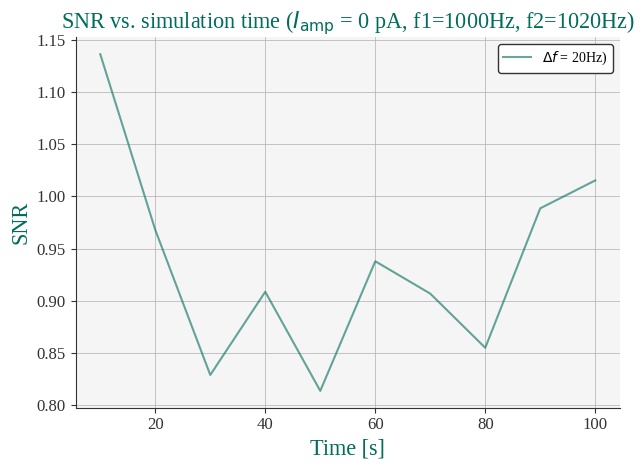

In [4]:
snr = SNR(a=0,sim_times=np.linspace(10e3,100e3,10), beat=20, f=1000, save_fig=True, N=1, return_SNR=True)

a=1000pA, f=1000Hz, SNR=3.88


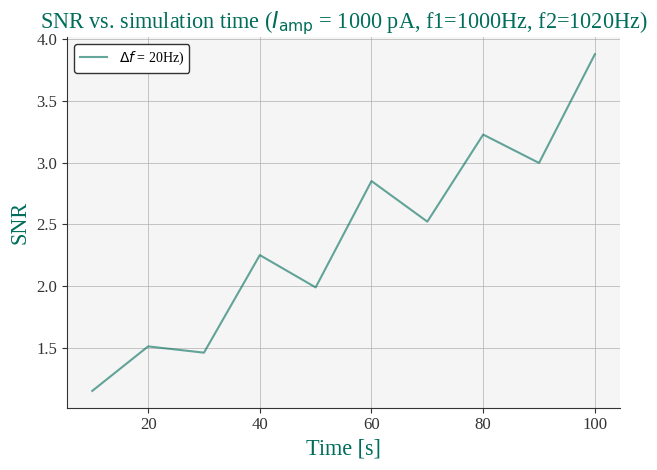

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/repo/results/hist-beat.png


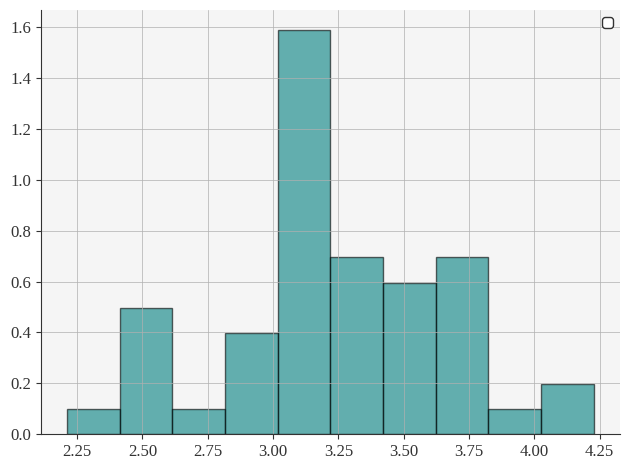

In [5]:
snr = SNR(a=1000,second_sine=True,sim_times=np.linspace(10e3,100e3,10), beat=20, f=1000, save_fig=True, N=50, return_SNR=True)

a=1000pA, f=1000Hz, SNR=0.82


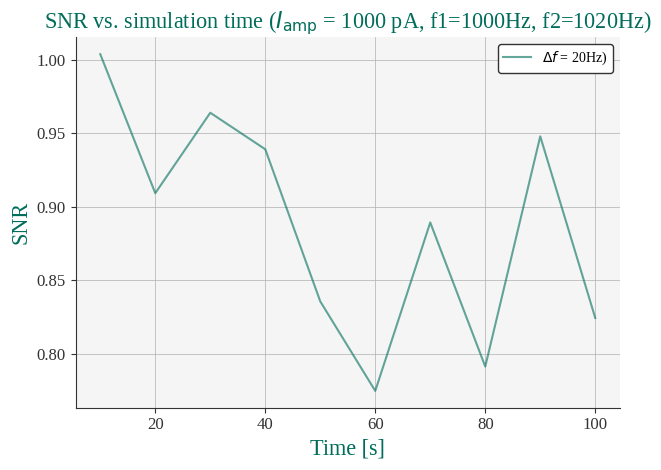

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/repo/results/hist-beat.png


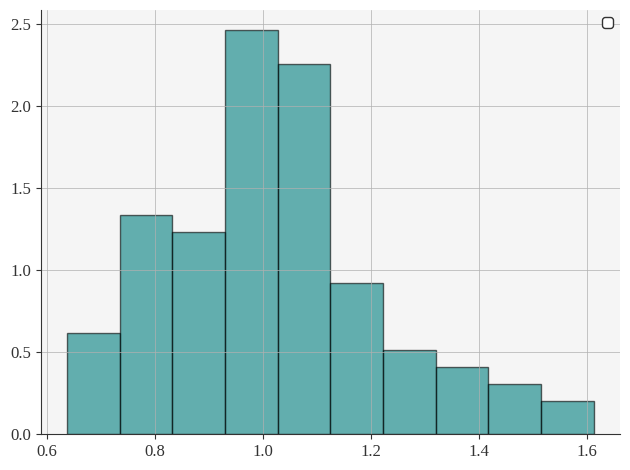

In [7]:
"""f = beat = 20 Hz"""

snr = SNR(a=1000,sim_times=np.linspace(10e3,100e3,10), beat=20, f=1000, save_fig=False, N=100, return_SNR=True)

In [25]:
print(f"mean:{np.nanmean(snr)}")
print(f"std:{np.std(snr)}")

mean:1.034138876594288
std:0.16986816325461343


In [11]:
def SNR_amp(sim_time, a_values, sd=250, noise_window=5, second_sine=False, f_values=[10,100,1000], bin_size=0.25, resolution=0.25):
    
    colors = ["seagreen", "mediumaquamarine", "cornflowerblue","gold", "magenta" ]
    for i, f in enumerate(f_values):
        SNR_list = []
        for j, a in enumerate(a_values): 
            
            results = build_simulation(sim_time=sim_time, noisy=True, second_sine=second_sine, resolution=0.25,
                                        f1=f, a=a, SD=sd, seed=42)
                    
            spike_times = results["spike_times"]
            
            results_noise = build_simulation(sim_time=sim_time, noisy=True, resolution=resolution,
                                    f1=f, a=0, SD=sd, second_sine=False, seed=42)
            
    
            #spike_times_noise = results_noise["spike_times"]
            freqs, psd_values = psd(spike_times, sim_time, bin_size=bin_size)
          #  psd_index = np.argmin(np.abs(freqs-f)) #finner indeksen nærmest f
                
           # freqs_noise, psd_values_noise = psd(spike_times_noise, sim_time, bin_size=bin_size)
           # noise_mask = (freqs_noise >= (freqs_noise[psd_index] - noise_window)) & (freqs_noise <= (freqs_noise[psd_index] + noise_window))
           # local_noise = psd_values_noise[noise_mask]
           # noise_avg = np.mean(np.abs(local_noise))
            
            SNR = compute_SNR(freqs, psd_values,  f)
            SNR_list.append(SNR)
            
        plt.plot(a_values, SNR_list, label=f"f={f}Hz", color=colors[i])
        plt.title(f"B. SNR vs Current Amplitude", 
                  fontsize=20, fontweight='bold', color="#006D5B")
        plt.xlabel(r"$I_{\mathrm{amp}}$ [pA]", fontsize=16)
        plt.ylabel("SNR", fontsize=16)
        plt.legend()
        
        ax = plt.gca()
        plot_layout(ax)
        plt.tight_layout()
        ax.set_xscale("log")
        ax.set_yscale("log")
    
        
    save_figure("SNR_vs_Iamp")       
    plt.tight_layout()
    plt.show()
    

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/repo/results/SNR_vs_Iamp.png


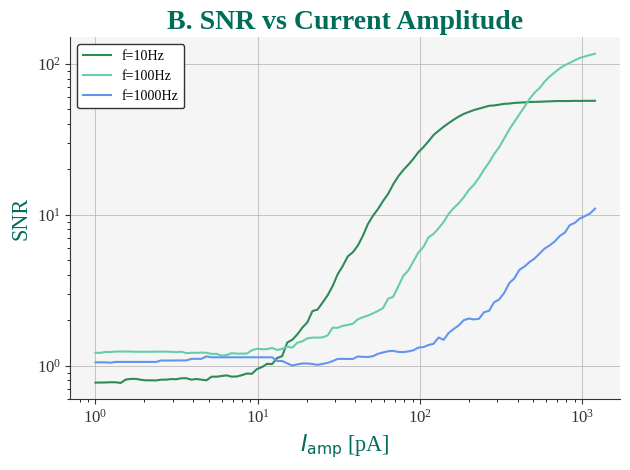

In [12]:
SNR_amp(sim_time=100e3, a_values=np.logspace(np.log10(1), np.log10(1200), 100), sd=250, second_sine=False, f_values=[10,100,1000], bin_size=0.25, resolution=0.25)

## SNR vs. frequency
Updated version - more accurate estimate of SNR \
Shows the same trend 

In [9]:
def SNR_f(sim_time, a_values, sd=250, noise_window=5, second_sine=False, f_values=[10,20], bin_size=0.25, beat=20, save_fig=False):

    colors = ["#009879", "teal", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B"]
    for i, a in enumerate(a_values):
        SNR_list = []
       
        for j, f in enumerate(f_values): 
            
            results =  build_simulation(sim_time=sim_time, noisy=True, resolution=0.25,
                                        f1=f, a=a, SD=sd, seed=42, second_sine=second_sine, beat=beat)
            spike_times = results["spike_times"]
            
            freqs, psd_values = psd(spike_times, sim_time, bin_size=bin_size)
            
            SNR = compute_SNR(freqs, psd_values, f)
            
            SNR_list.append(SNR)
            
        all_SNR_values = dict(zip(f_values, SNR_list))
        all_SNR_10Hz = SNR_list[np.argmin(np.abs(np.array(f_values) - 10))]
        arg_close_to_10Hz = np.argmin(np.abs(np.array(f_values) - 10))                                      
        
        # Plot
        plt.rcParams["font.family"] = "Liberation Serif"
        plt.plot(f_values, SNR_list, color=colors[i], label=rf"$I_\mathrm{{amp}} = {a}\,\mathrm{{pA}}$")
        plt.title(rf"A. SNR vs frequency", fontweight='bold', color="#006D5B", fontsize=20)
        plt.xlabel("Frequency [Hz]", fontsize=16)
        plt.ylabel("SNR", fontsize=16)
        plt.legend()
        ax = plt.gca() 
        plot_layout(ax)
        ax.set_yscale("log")
        ax.set_xscale("log")
        
    if save_fig:
        save_dir = os.path.join(os.getcwd(), "results")
        os.makedirs(save_dir, exist_ok=True)
        file_index = 1
        while os.path.exists(os.path.join(save_dir, f"SNR_f_{file_index}.png")):
            file_index += 1
        
        save_path = os.path.join(save_dir, f"SNR_f_{file_index}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
        
        print(f"Saved plot as: {save_path}")
            
    plt.tight_layout()
    plt.show()
    return SNR_list
    

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/repo/results/SNR_f_11.png


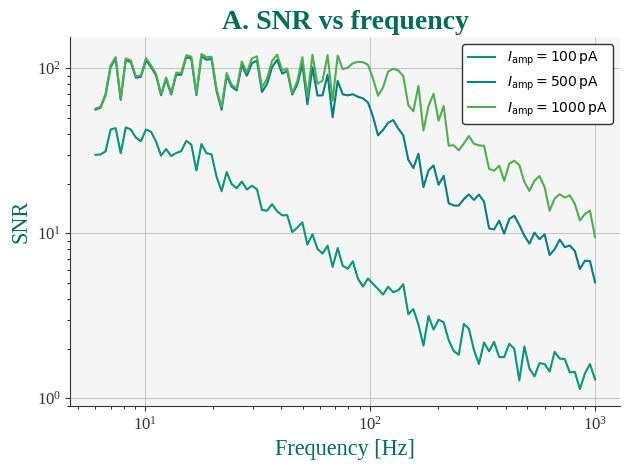

In [10]:
snr = SNR_f(sim_time=100e3, a_values=[100, 500, 1000], sd=250, second_sine=False, f_values=np.logspace(np.log10(6), np.log10(1000), 100), bin_size=0.25, save_fig=True)